# Mdai client library example

In [ ]:
import mdai

# or 

# see https://github.com/googledatalab/notebooks/blob/master/tutorials/BigQuery/Importing%20and%20Exporting%20Data.ipynb
# http://googledatalab.github.io/pydatalab/google.datalab.html
# use google.datalab Context 
from mdai import Context # maintains contextual state for connecting to the Cloud APIs? 

In [ ]:
# mockup 
from mdai import Client, Config 

 # maintains config for connecting to resources? or call this context 
Config.load_config() 
client = Client() 

project = client.load_project() # use config/environment variables 




### prepare data

In [2]:
project = mdai.load_project(id='x9N20BZa', access_token='ee4e4bf09139194db8c24cc4052245b1')

In [3]:
labels = project.labels(labelgroup=1)
labels

[('L_low', 'Lung Opacity (High Prob)'),
 ('L_8lk', 'Lung Opacity (Med Prob) '),
 ('L_gd9', 'Lung Opacity (Low Prob) '),
 ('L_68z', 'No Lung Opacity / Not Normal'),
 ('L_28r', 'Normal'),
 ('L_pyj', 'Question'),
 ('L_jrn', 'Exclude'),
 ('L_wl6', 'Adjudicate'),
 ('L_4kq', 'Question Addressed'),
 ('L_xjn', 'Classic')]

In [4]:
annotations = project.annotations(dataset=1, labels=('L_low', 'L_8lk', 'L_68z', 'L_28r'))
annotations[4]

{'id': 'A_rvl8g9',
 'createdAt': '2018-04-17T18:38:43.519Z',
 'createdById': 'U_rld',
 'updatedAt': '2018-04-17T18:38:50.502Z',
 'updatedById': 'U_rld',
 'StudyInstanceUID': '1.2.276.0.7230010.3.1.2.8323329.28530.1517874485.775525',
 'SeriesInstanceUID': '1.2.276.0.7230010.3.1.3.8323329.28530.1517874485.775524',
 'SOPInstanceUID': '1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526',
 'labelId': 'L_low',
 'annotationNumber': 1,
 'height': 1024,
 'width': 1024,
 'data': {'x': 337.50671,
  'y': 513.14798,
  'width': 159.5695,
  'height': 169.90132},
 'note': None,
 'radlexTagIds': []}

In [5]:
print(len(annotations))

13261


In [6]:
images_train, images_validation = project.images(dataset=1, shuffle=True, split=0.9)

print(len(images_train), len(images_validation))

8397 934


### config

In [7]:
import os
import sys
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pydicom
from imgaug import augmenters as iaa

# Root directory of the project
ROOT_DIR = os.path.abspath('../')

# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')

In [8]:
class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the pneumonia dataset.
    Overrides values in the base Config class.
    """
    NAME = 'pneumonia'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 16
    BACKBONE = 'resnet50'
    NUM_CLASSES = 3  # background + 2 pneumonia classes
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (32, 64, 128, 256)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 3
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.9
    DETECTION_NMS_THRESHOLD = 0.1
    
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     16
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.1
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 16
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               3
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_

In [9]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the pneumonia dataset.
    """

    def __init__(self, images, annotations_by_image, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'high_prob')
        self.add_class('pneumonia', 2, 'med_prob')

        # Add images
        for i, fp in enumerate(images):
            annotations = annotations_by_image[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                x = int(a['data']['x'])
                y = int(a['data']['y'])
                w = int(a['data']['width'])
                h = int(a['data']['height'])
                mask_instance = mask[:, :, i].copy()
                cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                mask[:, :, i] = mask_instance
                if a['labelId'] == 'L_low':
                    class_ids[i] = 1
                elif a['labelId'] == 'L_8lk':
                    class_ids[i] = 2
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [10]:
# Training dataset
dataset_train = DetectorDataset(images_train, annotations_by_image, 1024, 1024)
dataset_train.prepare()

# Validation dataset
dataset_val = DetectorDataset(images_validation, annotations_by_image, 1024, 1024)
dataset_val.prepare()

[2 1 2]


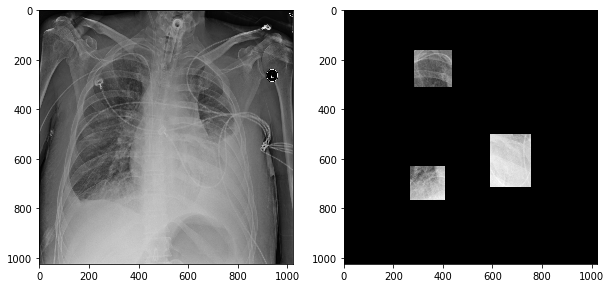

In [11]:
# Load and display random samples

image_id = random.choice(dataset_train.image_ids)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image[:, :, 0], cmap='gray')
plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')

print(class_ids)

### training

In [12]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=MODEL_DIR)

In [13]:
augmentation = iaa.SomeOf((0, 1), [
    iaa.Fliplr(0.5),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    ),
    iaa.Multiply((0.9, 1.1))
])

In [14]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=40, 
            layers='all',
            augmentation=augmentation)


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/jupyter/logs/pneumonia20180510T2011/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2

/home/leon/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/leon/miniconda3/lib/python3.6/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/40
 999/1000 [============================>.] - ETA: 0s - loss: 2.0402 - rpn_class_loss: 0.0739 - rpn_bbox_loss: 0.4316 - mrcnn_class_loss: 0.4418 - mrcnn_bbox_loss: 0.5708 - mrcnn_mask_loss: 0.5221

/home/leon/miniconda3/lib/python3.6/site-packages/keras/engine/training.py:2348: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


1000/1000 [==============================] - 1023s 1s/step - loss: 2.0396 - rpn_class_loss: 0.0739 - rpn_bbox_loss: 0.4314 - mrcnn_class_loss: 0.4416 - mrcnn_bbox_loss: 0.5707 - mrcnn_mask_loss: 0.5221 - val_loss: 1.7824 - val_rpn_class_loss: 0.0438 - val_rpn_bbox_loss: 0.3613 - val_mrcnn_class_loss: 0.4084 - val_mrcnn_bbox_loss: 0.5109 - val_mrcnn_mask_loss: 0.4580
Epoch 2/40
1000/1000 [==============================] - 908s 908ms/step - loss: 1.7277 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 0.3281 - mrcnn_class_loss: 0.4188 - mrcnn_bbox_loss: 0.4826 - mrcnn_mask_loss: 0.4567 - val_loss: 1.6762 - val_rpn_class_loss: 0.0373 - val_rpn_bbox_loss: 0.3128 - val_mrcnn_class_loss: 0.4043 - val_mrcnn_bbox_loss: 0.4828 - val_mrcnn_mask_loss: 0.4390
Epoch 3/40
1000/1000 [==============================] - 899s 899ms/step - loss: 1.6131 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.3058 - mrcnn_class_loss: 0.3923 - mrcnn_bbox_loss: 0.4451 - mrcnn_mask_loss: 0.4344 - val_loss: 1.5352 - val_rpn_class

### evaluate

In [15]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/jupyter/logs/pneumonia20180510T2011/mask_rcnn_pneumonia_0040.h5


In [16]:
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
        elif class_id == 2:
            colors.append((.973, .58, .024))
    return colors

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  247.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  143.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16320, 4)         min:   -0.70988  max:    1.58439  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  242.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  138.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16320, 4)         min:   -0.70988  max:    1.58439  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  247.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -118.70000  max:  143.10000

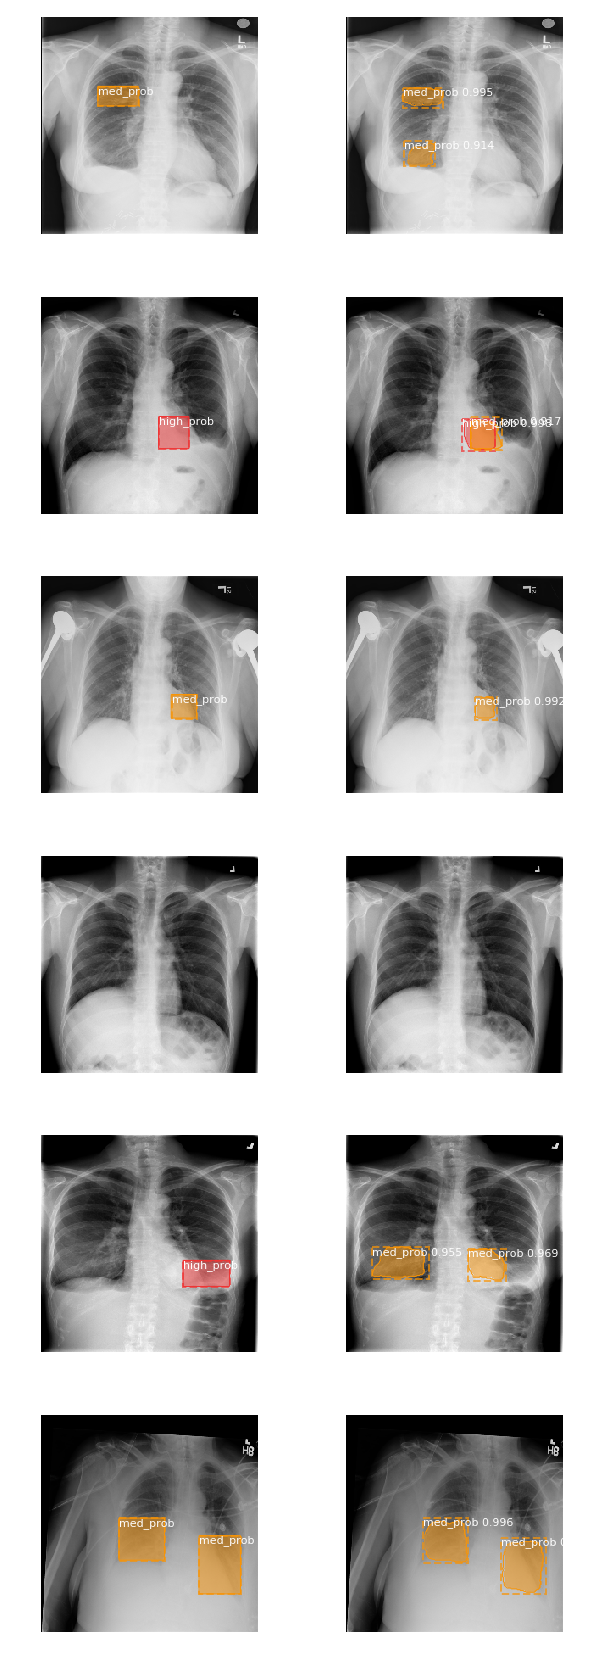

In [17]:
fig = plt.figure(figsize=(10, 30))

for i in range(6):

    image_id = random.choice(dataset_val.image_ids)
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
        
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset_train.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image], verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])